https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2

In [1]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
import matplotlib
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import plotly.offline as py
from plotly import tools
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from scipy.stats import gaussian_kde

plt.style.use('seaborn')
sns.set(font_scale=1.5)

import random
import gc 
# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_rows = 100
pd.options.display.max_columns = 1000

# 前のnotebookの関数達

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)
    
def count_categorical(df, group_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('object'))
    categorical[group_var] = df[group_var]
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    column_names = []
    for var in categorical.columns.levels[0]:
            for stat in ['count', 'count_norm']:
                column_names.append('%s_%s_%s' % (df_name, var, stat))
    categorical.columns = column_names
    return categorical

def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

def agg_numeric(df, parent_var, df_name):
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    columns = []

    for var in agg.columns.levels[0]:
        if var != parent_var:
            for stat in agg.columns.levels[1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
    
def remove_missing_columns(train, test, threshold = 90):
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    return train, test

def agg_categorical(df, parent_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('object'))

    categorical[parent_var] = df[parent_var]

    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    for var in categorical.columns.levels[0]:
        for stat in ['sum', 'count', 'mean']:
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

def feature_importance_plot(df):
    a = df[["Feature_fold1","Importance_fold1"]]
    b = df[["Feature_fold2","Importance_fold2"]].rename(columns={"Feature_fold2":"Feature_fold1", "Importance_fold2":"Importance_fold1"})
    c = df[["Feature_fold3","Importance_fold3"]].rename(columns={"Feature_fold3":"Feature_fold1", "Importance_fold3":"Importance_fold1"})
    d = df[["Feature_fold4","Importance_fold4"]].rename(columns={"Feature_fold4":"Feature_fold1", "Importance_fold4":"Importance_fold1"})
    # e = df[["Feature_fold5","Importance_fold5"]].rename(columns={"Feature_fold5":"Feature_fold1", "Importance_fold5":"Importance_fold1"})
    
    feat = pd.concat([a, b, c, d]).reset_index()
    indices = feat.groupby("Feature_fold1")["Importance_fold1"].agg("mean").reset_index().sort_values("Importance_fold1", ascending=False)[["Feature_fold1",'Importance_fold1']]
    plt.figure(figsize=(10,14))
    plt.title("重要度上位50")
    sns.barplot(x="Importance_fold1", y="Feature_fold1", data=feat, order=indices.iloc[:50, 0])
    return indices

In [3]:
import sys

# データが何GBかを指す
def return_size(df):
    return round(sys.getsizeof(df) / 1e9, 2)

# データを軽くする
def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    for c in df:
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)       
    new_memory = df.memory_usage().sum()
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')   
        print(df.shape)
    return df

In [4]:
POS_CASH_balance = pd.read_pickle('../home credit/POS_CASH_balance.pickle')
bureau_balance = pd.read_pickle('../home credit/bureau_balance.pickle')
application_train = pd.read_pickle('../home credit/application_train.pickle')
previous_application = pd.read_pickle('../home credit/previous_application.pickle')
installments_payments = pd.read_pickle('../home credit/installments_payments.pickle')
credit_card_balance = pd.read_pickle('../home credit/credit_card_balance.pickle')
application_test = pd.read_pickle('../home credit/application_test.pickle')
bureau = pd.read_pickle('../home credit/bureau.pickle')
description = pd.read_csv('../home credit/HomeCredit_columns_description.csv', index_col=0).iloc[:,0:5]
train_bureau_corrs_removed = pd.read_pickle('../home credit/train_bureau_corrs_removed.pkl')
test_bureau_corrs_removed = pd.read_pickle('../home credit/test_bureau_corrs_removed.pkl')
pd.options.display.max_colwidth = 20000
def search_description(column):
    return description.loc[description.Row == column][['Description','日本語訳']]

# ひたすら集計してjoinしていく

# previous_application

In [5]:
previous = convert_types(previous_application, print_info=True)
previous.head()

Original Memory Usage: 0.32 gb.
New Memory Usage: 0.32 gb.
(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,True,0.0,0.182861,0.867188,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,True,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,True,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,True,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,True,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

Previous aggregation shape:  (338857, 80)


,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_FIRST_DUE_max,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,previous_DAYS_LAST_DUE_mean,previous_DAYS_LAST_DUE_max,previous_DAYS_TERMINATION_sum,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_mean,previous_DAYS_TERMINATION_max,previous_DAYS_LAST_DUE_1ST_VERSION_sum,previous_DAYS_LAST_DUE_1ST_VERSION_min,previous_DAYS_LAST_DUE_1ST_VERSION_mean,previous_DAYS_LAST_DUE_1ST_VERSION_max,previous_RATE_INTEREST_PRIMARY_sum,previous_RATE_INTEREST_PRIVILEGED_sum,previous_RATE_INTEREST_PRIMARY_count,previous_NFLAG_INSURED_ON_APPROVAL_min,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_NFLAG_INSURED_ON_APPROVAL_max,previous_NFLAG_INSURED_ON_APPROVAL_sum,previous_RATE_DOWN_PAYMENT_min,previous_RATE_DOWN_PAYMENT_mean,previous_RATE_DOWN_PAYMENT_max,previous_RATE_DOWN_PAYMENT_sum,previous_AMT_DOWN_PAYMENT_count,previous_DAYS_FIRST_DRAWING_count,previous_AMT_GOODS_PRICE_count,previous_AMT_ANNUITY_count,previous_CNT_PAYMENT_count,previous_AMT_CREDIT_count,previous_AMT_APPLICATION_count,previous_CNT_PAYMENT_min,previous_CNT_PAYMENT_mean,previous_CNT_PAYMENT_max,previous_CNT_PAYMENT_sum,previous_HOUR_APPR_PROCESS_START_min,previous_HOUR_APPR_PROCESS_START_mean,previous_HOUR_APPR_PROCESS_START_max,previous_HOUR_APPR_PROCESS_START_sum,previous_SELLERPLACE_AREA_min,previous_SELLERPLACE_AREA_mean,previous_SELLERPLACE_AREA_max,previous_SELLERPLACE_AREA_sum,previous_AMT_DOWN_PAYMENT_min,previous_AMT_DOWN_PAYMENT_mean,previous_AMT_DOWN_PAYMENT_max,previous_AMT_DOWN_PAYMENT_sum,previous_AMT_ANNUITY_min,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_sum,previous_AMT_CREDIT_min,previous_AMT_CREDIT_mean,previous_AMT_CREDIT_max,previous_AMT_CREDIT_sum,previous_AMT_APPLICATION_min,previous_AMT_GOODS_PRICE_min,previous_AMT_APPLICATION_mean,previous_AMT_GOODS_PRICE_mean,previous_AMT_APPLICATION_max,previous_AMT_GOODS_PRICE_max,previous_AMT_GOODS_PRICE_sum,previous_AMT_APPLICATION_sum,previous_DAYS_FIRST_DRAWING_min,previous_DAYS_FIRST_DRAWING_mean,previous_DAYS_FIRST_DRAWING_max,previous_DAYS_FIRST_DRAWING_sum,previous_RATE_INTEREST_PRIMARY_min,previous_RATE_INTEREST_PRIMARY_mean,previous_RATE_INTEREST_PRIMARY_max,previous_RATE_INTEREST_PRIVILEGED_min,previous_RATE_INTEREST_PRIVILEGED_mean,previous_RATE_INTEREST_PRIVILEGED_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-1740.0,-1740,-1740.0,-1740,-1709.0,-1709.0,-1709.000000,-1709.0,-1619.0,-1619.0,-1619.000000,-1619.0,-1612.0,-1612.0,-1612.000000,-1612.0,-1499.0,-1499.0,-1499.000000,-1499.0,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.104309,0.104309,0.104309,0.104309,1,1,1,1,1,1,1,8.0,8.0,8.0,8.0,13,13.000000,13,13.0,23,23.0,23,23,2520.0,2520.0,2520.0,2520.0,3951.000000,3951.000000,3951.000000,3951.000000,23787.0,23787.00,23787.0,23787.0,24835.5,24835.5,24835.50,24835.5,24835.5,24835.5,24835.5,24835.5,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100002,-606.0,-606,-606.0,-606,-565.0,-565.0,-565.000000,-565.0,-25.0,-25.0,-25.000000,-25.0,-17.0,-17.0,-17.000000,-17.0,125.0,125.0,125.000000,125.0,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1,1,1,1,1,1,1,24.0,24.0,24.0,24.0,9,9.000000,9,9.0,500,500.0,500,500,0.0,0.0,0.0,0.0,9251.775391,9251.775391,9251.775391,9251.775391,179055.0,179055.00,179055.0,179055.0,179055.0,179055.0,179055.00,179055.0,179055.0,179055.0,179055.0,179055.0,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100003,-3915.0,-2341,-1305.0,-746,-3823.0,-2310.0,-1274.333374,-716.0,-3163.0,-1980.0,-1054.333374,-536.0,-3142.0,-1976.0,-1047.333374,-527.0,-3013.0,-1980.0,-1004.333313,-386.0,0.0,0.0,0,0.0,0.666504,1.0,2.0,0.000000,0.050018,0.100037,0.100037,2,3,3,3,3,3,3,6.0,10.0,12.0,30.0,12,14.666667,17,44.0,-1,533.0,1400,1599,0.0,3442.5,6885.0,6885.0,6737.310059,

In [7]:
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

Previous counts shape:  (338857, 285)


,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_Animals_sum,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_GOODS_CATEGORY_House Construction_sum,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,previous_NAME_GOODS_CATEGORY_Education_mean,previous_NAME_GOODS_CATEGORY_Education_sum,previous_NAME_GOODS_CATEGORY_Additional Service_mean,previous_NAME_GOODS_CATEGORY_Additional Service_sum,previous_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_mean,previous_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a garage_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a garage_sum,previous_NAME_GOODS_CATEGORY_Insurance_mean,previous_NAME_GOODS_CATEGORY_Insurance_sum,previous_NAME_CASH_LOAN_PURPOSE_Business development_mean,previous_NAME_CASH_LOAN_PURPOSE_Business development_sum,previous_NAME_GOODS_CATEGORY_Fitness_mean,previous_NAME_GOODS_CATEGORY_Fitness_sum,previous_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_mean,previous_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_sum,previous_NAME_SELLER_INDUSTRY_MLM partners_mean,previous_NAME_SELLER_INDUSTRY_MLM partners_sum,previous_NAME_GOODS_CATEGORY_Direct Sales_mean,previous_NAME_GOODS_CATEGORY_Direct Sales_sum,previous_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_mean,previous_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_sum,previous_NAME_CASH_LOAN_PURPOSE_Journey_mean,previous_NAME_CASH_LOAN_PURPOSE_Journey_sum,previous_NAME_CASH_LOAN_PURPOSE_Furniture_mean,previous_NAME_CASH_LOAN_PURPOSE_Furniture_sum,previous_NAME_GOODS_CATEGORY_Weapon_mean,previous_NAME_GOODS_CATEGORY_Weapon_sum,previous_CODE_REJECT_REASON_SYSTEM_mean,previous_CODE_REJECT_REASON_SYSTEM_sum,previous_NAME_CONTRACT_TYPE_XNA_mean,previous_NAME_CONTRACT_TYPE_XNA_sum,previous_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_mean,previous_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_sum,previous_NAME_GOODS_CATEGORY_Medicine_mean,previous_NAME_GOODS_CATEGORY_Medicine_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,previous_NAME_GOODS_CATEGORY_Sport and Leisure_sum,previous_CHANNEL_TYPE_Car dealer_mean,previous_NAME_PORTFOLIO_Cars_mean,previous_CHANNEL_TYPE_Car dealer_sum,previous_NAME_PORTFOLIO_Cars_sum,previous_NAME_CASH_LOAN_PURPOSE_Car repairs_mean,previous_NAME_CASH_LOAN_PURPOSE_Car repairs_sum,previous_NAME_TYPE_SUITE_Group of people_mean,previous_NAME_TYPE_SUITE_Group of people_sum,previous_NAME_SELLER_INDUSTRY_Jewelry_mean,previous_NAME_SELLER_INDUSTRY_Jewelry_sum,previous_NAME_PAYMENT_TYPE_Cashless from the account of the employer_mean,previous_NAME_PAYMENT_TYPE_Cashless from the account of the employer_sum,previous_NAME_PAYMENT_TYPE_Non-cash from your account_mean,previous_NAME_PAYMENT_TYPE_Non-cash from your account_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a home_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a home_sum,previous_NAME_SELLER_INDUSTRY_Tourism_mean,previous_NAME_GOODS_CATEGORY_Tourism_mean,previous_CODE_REJECT_REASON_XNA_mean,previous_NAME_SELLER_INDUSTRY_Tourism_sum,previous_NAME_GOODS_CATEGORY_Tourism_sum,previous_CODE_REJECT_REASON_XNA_sum,previous_NAME_CASH_LOAN_PURPOSE_Medicine_mean,previous_NAME_CASH_LOAN_PURPOSE_Medicine_sum,previous_NAME_GOODS_CATEGORY_Office Appliances_mean,previous_NAME_GOODS_CATEGORY_Office Appliances_sum,previous_NAME_GOODS_CATEGORY_Jewelry_mean,previous_NAME_GOODS_CATEGORY_Jewelry_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a new car_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a new car_sum,previous_NAME_GOODS_CATEGORY_Other_mean,previous_

In [8]:
train = convert_types(train_bureau_corrs_removed)
test = convert_types(test_bureau_corrs_removed)

# Merge in the previous information
train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test = test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

0

In [9]:
train, test = remove_missing_columns(train, test)

There are 6 columns with greater than 90% missing values.


# previousの紐づくほかのテーブル

In [10]:
# 集計の処理を数値カテゴリ同時に行う関数を定義
def aggregate_client(df, group_vars, df_names):

    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    if any(df.dtypes == 'object'):
        # SK_ID_PREVごとに集計
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        #数値変数、カテゴリ変数ごとに集計して、くっつけたもの
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        #df_by_loanにSK_ID_CURRをくっつける
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # SK_ID_PREVを削除
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # SK_ID_CURRごとに集計
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # カテゴリ変数がない場合は上記を一部省略
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

# 2回集計をしているので、ラグ特徴量を作る際には注意が必要

# POS_CASH_balance

In [11]:
cash = convert_types(POS_CASH_balance, print_info=True)
cash.head()

Original Memory Usage: 0.25 gb.
New Memory Usage: 0.25 gb.
(10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [12]:
print(len(train.SK_ID_CURR.unique()))
print(len(test.SK_ID_CURR.unique()))
print(len(train.SK_ID_CURR.unique()) + len(test.SK_ID_CURR.unique()))
print(len(cash.SK_ID_CURR.unique()))
print(len(cash.SK_ID_PREV.unique()))

307511
48744
356255
337252
936325


In [13]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,client_cash_MONTHS_BALANCE_min_mean,client_cash_MONTHS_BALANCE_mean_mean,client_cash_MONTHS_BALANCE_max_mean,client_cash_MONTHS_BALANCE_min_max,client_cash_MONTHS_BALANCE_mean_max,client_cash_MONTHS_BALANCE_max_max,client_cash_NAME_CONTRACT_STATUS_XNA_mean_min,client_cash_SK_DPD_DEF_min_min,client_cash_NAME_CONTRACT_STATUS_Canceled_mean_min,client_cash_NAME_CONTRACT_STATUS_Canceled_sum_min,client_cash_NAME_CONTRACT_STATUS_Amortized debt_mean_min,client_cash_NAME_CONTRACT_STATUS_Amortized debt_sum_min,client_cash_NAME_CONTRACT_STATUS_XNA_mean_mean,client_cash_NAME_CONTRACT_STATUS_XNA_mean_max,client_cash_NAME_CONTRACT_STATUS_XNA_sum_mean,client_cash_NAME_CONTRACT_STATUS_XNA_sum_max,client_cash_NAME_CONTRACT_STATUS_XNA_mean_sum,client_cash_NAME_CONTRACT_STATUS_XNA_sum_sum,client_cash_SK_DPD_min_min,client_cash_SK_DPD_DEF_min_mean,client_cash_SK_DPD_DEF_min_max,client_cash_SK_DPD_DEF_min_sum,client_cash_NAME_CONTRACT_STATUS_Canceled_mean_mean,client_cash_NAME_CONTRACT_STATUS_Canceled_mean_max,client_cash_NAME_CONTRACT_STATUS_Canceled_sum_mean,client_cash_NAME_CONTRACT_STATUS_Canceled_mean_sum,client_cash_NAME_CONTRACT_STATUS_Canceled_sum_max,client_cash_NAME_CONTRACT_STATUS_Canceled_sum_sum,client_cash_NAME_CONTRACT_STATUS_Amortized debt_mean_mean,client_cash_NAME_CONTRACT_STATUS_Amortized debt_mean_max,client_cash_NAME_CONTRACT_STATUS_Amortized debt_sum_mean,client_cash_NAME_CONTRACT_STATUS_Amortized debt_mean_sum,client_cash_NAME_CONTRACT_STATUS_Amortized debt_sum_max,client_cash_NAME_CONTRACT_STATUS_Amortized debt_sum_sum,client_cash_NAME_CONTRACT_STATUS_Demand_mean_min,client_cash_NAME_CONTRACT_STATUS_Demand_mean_mean,client_cash_NAME_CONTRACT_STATUS_Demand_mean_max,client_cash_NAME_CONTRACT_STATUS_Demand_sum_min,client_cash_NAME_CONTRACT_STATUS_Demand_sum_mean,client_cash_NAME_CONTRACT_STATUS_Demand_mean_sum,client_cash_NAME_CONTRACT_STATUS_Demand_sum_max,client_cash_NAME_CONTRACT_STATUS_Demand_sum_sum,client_cash_NAME_CONTRACT_STATUS_Approved_mean_min,client_cash_NAME_CONTRACT_STATUS_Approved_sum_min,client_cash_SK_DPD_min_mean,client_cash_SK_DPD_min_max,client_cash_SK_DPD_min_sum,client_cash_NAME_CONTRACT_STATUS_Approved_mean_mean,client_cash_NAME_CONTRACT_STATUS_Approved_mean_max,client_cash_NAME_CONTRACT_STATUS_Approved_sum_mean,client_cash_NAME_CONTRACT_STATUS_Approved_sum_max,client_cash_NAME_CONTRACT_STATUS_Approved_mean_sum,client_cash_NAME_CONTRACT_STATUS_Approved_sum_sum,client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_min,client_cash_NAME_CONTRACT_STATUS_Returned to the store_sum_min,client_cash_SK_DPD_DEF_mean_min,client_cash_SK_DPD_mean_min,client_cash_SK_DPD_DEF_max_min,client_cash_SK_DPD_DEF_sum_min,client_cash_SK_DPD_max_min,client_cash_SK_DPD_sum_min,client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_mean,client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_max,client_cash_NAME_CONTRACT_STATUS_Returned to the store_sum_mean,client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_sum,client_cash_NAME_CONTRACT_STATUS_Returned to the store_sum_max,client_cash_NAME_CONTRACT_STATUS_Returned to the store_sum_sum,client_cash_NAME_CONTRACT_STATUS_Signed_mean_min,client_cash_NAME_CONTRACT_STATUS_Signed_mean_max,client_cash_NAME_CONTRACT_STATUS_Signed_mean_mean,client_cash_NAME_CONTRACT_STATUS_Signed_sum_min,client_cash_NAME_CONTRACT_STATUS_Signed_sum_mean,client_cash_NAME_CONTRACT_STATUS_Signed_sum_max,client_cash_NAME_CONTRACT_STATUS_Signed_mean_sum,client_cash_NAME_CONTRACT_STATUS_Signed_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_min_min,client_cash_CNT_INSTALMENT_FUTURE_min_mean,client_cash_CNT_INSTALMENT_FUTURE_min_max,client_cash_CNT_I

In [14]:
print('Cash by Client Shape: ', cash_by_client.shape)
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

Cash by Client Shape:  (337252, 165)


0

In [15]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


# credit_card_balance

In [16]:
credit = convert_types(credit_card_balance, print_info = True)
credit.head()

Original Memory Usage: 0.3 gb.
New Memory Usage: 0.3 gb.
(3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,1800.0,1800.0,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,2250.0,2250.0,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,2250.0,2250.0,26926.425781,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,11925.0,11925.0,224949.281250,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,27000.0,27000.0,443044.406250,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [17]:
search_description('AMT_BALANCE')

,Description,日本語訳
156,Balance during the month of previous credit,以前の信用の月の間にバランス


In [18]:
print(len(train.SK_ID_CURR.unique()))
print(len(test.SK_ID_CURR.unique()))
print(len(train.SK_ID_CURR.unique()) + len(test.SK_ID_CURR.unique()))
print(len(credit.SK_ID_CURR.unique()))
print(len(credit.SK_ID_PREV.unique()))

307511
48744
356255
103558
104307


In [19]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,client_credit_MONTHS_BALANCE_min_max,client_credit_MONTHS_BALANCE_mean_min,client_credit_MONTHS_BALANCE_mean_mean,client_credit_MONTHS_BALANCE_mean_max,client_credit_MONTHS_BALANCE_max_mean,client_credit_AMT_RECIVABLE_min_sum,client_credit_AMT_TOTAL_RECEIVABLE_min_sum,client_credit_AMT_RECIVABLE_min_min,client_credit_AMT_TOTAL_RECEIVABLE_min_min,client_credit_AMT_RECIVABLE_min_mean,client_credit_AMT_TOTAL_RECEIVABLE_min_mean,client_credit_AMT_RECIVABLE_min_max,client_credit_AMT_TOTAL_RECEIVABLE_min_max,client_credit_SK_DPD_min_mean,client_credit_SK_DPD_min_sum,client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_sum,client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Demand_mean_min,client_credit_NAME_CONTRACT_STATUS_Demand_sum_min,client_credit_NAME_CONTRACT_STATUS_Approved_mean_max,client_credit_NAME_CONTRACT_STATUS_Approved_mean_mean,client_credit_NAME_CONTRACT_STATUS_Approved_sum_mean,client_credit_NAME_CONTRACT_STATUS_Approved_mean_sum,client_credit_NAME_CONTRACT_STATUS_Approved_sum_sum,client_credit_NAME_CONTRACT_STATUS_Demand_mean_mean,client_credit_NAME_CONTRACT_STATUS_Demand_mean_max,client_credit_NAME_CONTRACT_STATUS_Demand_sum_mean,client_credit_NAME_CONTRACT_STATUS_Demand_sum_max,client_credit_NAME_CONTRACT_STATUS_Demand_mean_sum,client_credit_NAME_CONTRACT_STATUS_Demand_sum_sum,client_credit_NAME_CONTRACT_STATUS_Refused_mean_max,client_credit_NAME_CONTRACT_STATUS_Refused_mean_mean,client_credit_NAME_CONTRACT_STATUS_Refused_sum_mean,client_credit_NAME_CONTRACT_STATUS_Refused_mean_sum,client_credit_NAME_CONTRACT_STATUS_Refused_sum_sum,client_credit_NAME_CONTRACT_STATUS_Sent proposal_mean_mean,client_credit_NAME_CONTRACT_STATUS_Sent proposal_mean_min,client_credit_NAME_CONTRACT_STATUS_Sent proposal_mean_max,client_credit_NAME_CONTRACT_STATUS_Sent proposal_mean_sum,client_credit_NAME_CONTRACT_STATUS_Sent proposal_sum_min,client_credit_NAME_CONTRACT_STATUS_Sent proposal_sum_mean,client_credit_NAME_CONTRACT_STATUS_Sent proposal_sum_max,client_credit_NAME_CONTRACT_STATUS_Sent proposal_sum_sum,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_AMT_DRAWINGS_POS_CURRENT_min_sum,client_credit_AMT_INST_MIN_REGULARITY_min_min,client_credit_AMT_INST_MIN_REGULARITY_min_mean,client_credit_AMT_INST_MIN_REGULARITY_min_max,client_credit_AMT_INST_MIN_REGULARITY_min_sum,client_credit_CNT_DRAWINGS_CURRENT_min_min,client_credit_CNT_DRAWINGS_CURRENT_min_mean,client_credit_CNT_DRAWINGS_CURRENT_min_max,client_credit_CNT_DRAWINGS_ATM_CURRENT_min_sum,client_credit_CNT_DRAWINGS_CURRENT_min_sum,client_credit_AMT_DRAWINGS_CURRENT_min_min,client_credit_AMT_DRAWINGS_CURRENT_min_mean,client_credit_AMT_DRAWINGS_CURRENT_min_max,client_credit_AMT_PAYMENT_TOTAL_CURRENT_min_min,client_credit_AMT_PAYMENT_TOTAL_CURRENT_min_mean,client_credit_AMT_PAYMENT_TOTAL_CURRENT_min_max,client_credit_AMT_DRAWINGS_ATM_CURRENT_min_sum,client_credit_AMT_DRAWINGS_CURRENT_min_sum,client_credit_AMT_RECEIVABLE_PRINCIPAL_min_min,client_credit_AMT_RECEIVABLE_PRINCIPAL_min_mean,client_credit_AMT_RECEIVABLE_PRINCIPAL_min_max,client_credit_AMT_PAYMENT_TOTAL_CURRENT_min_sum,client_credit_AMT_BALANCE_min_min,client_credit_AMT_BALANCE_min_mean,client_credit_AMT_BALANCE_min_max,client_credit_AMT_RECEIVABLE_PRINCIPAL_min_sum,client_credit_AMT_BALANCE_min_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Signed_mean_min,client_credit_NAME_CONTRACT_STATUS_Signed_mean_max,client_credit_NAME_CONTRACT_STATUS_Signed_mean_mean,client_credit_NAME_CONTRACT_STATUS_Signed_sum_min,client_credit_NAME_CONTRACT_STATUS_Signed_sum_mean,client_credit_NAME_CONTRACT_STATUS_Signed_sum_max,client_credit_NAME_C

In [20]:
print('Credit by client shape: ', credit_by_client.shape)

train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

Credit by client shape:  (103558, 381)


0

In [21]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


# Installment Payments(分割払いのデータ)

In [22]:
installments = convert_types(installments_payments, print_info = True)
installments.head()

Original Memory Usage: 0.33 gb.
New Memory Usage: 0.33 gb.
(13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [23]:
installments.query('SK_ID_PREV==151639')

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT


In [24]:
print(len(train.SK_ID_CURR.unique()))
print(len(test.SK_ID_CURR.unique()))
print(len(train.SK_ID_CURR.unique()) + len(test.SK_ID_CURR.unique()))
print(len(installments.SK_ID_CURR.unique()))
print(len(installments.SK_ID_PREV.unique()))

307511
48744
356255
339587
997752


In [25]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_mean,client_installments_DAYS_INSTALMENT_sum_mean,client_installments_DAYS_ENTRY_PAYMENT_sum_max,client_installments_DAYS_INSTALMENT_sum_max,client_installments_DAYS_ENTRY_PAYMENT_min_min,client_installments_DAYS_INSTALMENT_min_min,client_installments_DAYS_INSTALMENT_mean_min,client_installments_DAYS_ENTRY_PAYMENT_mean_min,client_installments_DAYS_ENTRY_PAYMENT_max_min,client_installments_DAYS_INSTALMENT_max_min,client_installments_DAYS_ENTRY_PAYMENT_min_mean,client_installments_DAYS_INSTALMENT_min_mean,client_installments_DAYS_ENTRY_PAYMENT_mean_mean,client_installments_DAYS_INSTALMENT_mean_mean,client_installments_DAYS_ENTRY_PAYMENT_max_mean,client_installments_DAYS_INSTALMENT_max_mean,client_installments_DAYS_ENTRY_PAYMENT_min_max,client_installments_DAYS_INSTALMENT_min_max,client_installments_DAYS_ENTRY_PAYMENT_mean_max,client_installments_DAYS_INSTALMENT_mean_max,client_installments_DAYS_ENTRY_PAYMENT_max_max,client_installments_DAYS_INSTALMENT_max_max,client_installments_NUM_INSTALMENT_VERSION_min_min,client_installments_NUM_INSTALMENT_NUMBER_min_min,client_installments_NUM_INSTALMENT_VERSION_min_mean,client_installments_NUM_INSTALMENT_VERSION_min_max,client_installments_NUM_INSTALMENT_VERSION_mean_min,client_installments_NUM_INSTALMENT_VERSION_max_min,client_installments_NUM_INSTALMENT_VERSION_mean_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,client_installments_NUM_INSTALMENT_NUMBER_min_mean,client_installments_NUM_INSTALMENT_VERSION_max_mean,client_installments_NUM_INSTALMENT_NUMBER_min_max,client_installments_NUM_INSTALMENT_VERSION_max_max,client_installments_NUM_INSTALMENT_NUMBER_mean_min,client_installments_NUM_INSTALMENT_NUMBER_mean_mean,client_installments_NUM_INSTALMENT_NUMBER_mean_max,client_installments_DAYS_ENTRY_PAYMENT_count_min,client_installments_NUM_INSTALMENT_VERSION_count_min,client_installments_NUM_INSTALMENT_VERSION_sum_min,client_installments_DAYS_ENTRY_PAYMENT_count_mean,client_installments_NUM_INSTALMENT_VERSION_count_mean,client_installments_NUM_INSTALMENT_NUMBER_max_min,client_installments_NUM_INSTALMENT_NUMBER_max_mean,client_installments_NUM_INSTALMENT_NUMBER_max_max,client_installments_DAYS_ENTRY_PAYMENT_count_max,client_installments_NUM_INSTALMENT_VERSION_count_max,client_installments_NUM_INSTALMENT_VERSION_sum_mean,client_installments_NUM_INSTALMENT_VERSION_sum_max,client_installments_DAYS_ENTRY_PAYMENT_min_count,client_installments_DAYS_ENTRY_PAYMENT_sum_count,client_installments_NUM_INSTALMENT_VERSION_min_sum,client_installments_NUM_INSTALMENT_VERSION_mean_sum,client_installments_NUM_INSTALMENT_NUMBER_sum_min,client_installments_NUM_INSTALMENT_NUMBER_sum_mean,client_installments_NUM_INSTALMENT_NUMBER_min_sum,client_installments_NUM_INSTALMENT_NUMBER_sum_max,client_installments_NUM_INSTALMENT_VERSION_max_sum,client_installments_NUM_INSTALMENT_NUMBER_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_count_sum,client_installments_NUM_INSTALMENT_VERSION_count_sum,client_installments_NUM_INSTALMENT_NUMBER_max_sum,client_installments_NUM_INSTALMENT_VERSION_sum_sum,client_installments_NUM_INSTALMENT_NUMBER_sum_sum,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_INSTALMENT_min_min,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_INSTALMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_INSTALMENT_min_max,client_installments_AMT_PAYMENT_mean_min,client_installments_AMT_INSTALMENT_mean_min,client_installments_AMT_INSTALMENT_max_min,client_i

In [26]:
print('Installments by client shape: ', installments_by_client.shape)

train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

Installments by client shape:  (339587, 106)


0

In [27]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


##### ここまでで単純な集計は完了

In [28]:
print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

Final Training Shape:  (307511, 1198)
Final Testing Shape:  (48744, 1197)


In [29]:
print(f'Final training size: {return_size(train)}')
print(f'Final testing size: {return_size(test)}')

Final training size: 2.36
Final testing size: 0.37


In [30]:
train.to_pickle('previous_feature_train.pkl')
test.to_pickle('previous_feature_test.pkl')

# 一旦LGBMに突っ込む

In [31]:
def num_cat(df):
    num_f = df.dtypes[df.dtypes != 'object'].index
    cat_f = df.dtypes[df.dtypes == 'object'].index
    return num_f, cat_f

In [32]:
train = pd.read_pickle('../home credit/previous_feature_train.pkl')
test = pd.read_pickle('../home credit/previous_feature_test.pkl')

for c in train.columns:
    if train[c].dtypes == 'bool':
        train[c] = train[c].astype(np.int8)
        
for c in test.columns:
    if test[c].dtypes == 'bool':
        test[c] = test[c].astype(np.int8)
        
train_y = train['TARGET']

df = pd.concat([train.drop('TARGET',axis=1), test], sort=False).reset_index(drop=True)
docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
df['NEW_DOC_IND_AVG'] = df[docs].mean(axis=1)
df['NEW_DOC_IND_STD'] = df[docs].std(axis=1)
df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
df['NEW_LIVE_IND_STD'] = df[live].std(axis=1)
df['NEW_LIVE_IND_KURT'] = df[live].kurtosis(axis=1)
df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
df['NEW_PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['app EXT_SOURCE_1 / DAYS_BIRTH'] = df['EXT_SOURCE_1'] / df['DAYS_BIRTH']
df['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / 12. - df['AMT_ANNUITY']
df['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / df['AMT_ANNUITY']
df['MANY_CHILDREN'] = (df["CNT_CHILDREN"] > 5) * 1
df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

train_df = df[:len(train)]
test_df = df[len(train):].reset_index(drop=True)

num_f, cat_f = num_cat(train_df)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df[cat_f] = train_df[cat_f].fillna('nan')
test_df[cat_f] = test_df[cat_f].fillna('nan')

df = pd.concat([train_df, test_df], sort=False)
for cat in cat_f:
    df[cat] = le.fit_transform(df[cat])
train_df = df[:len(train_df)]
test_df = df[len(train_df):]

In [225]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
sampler = RandomUnderSampler(random_state=42)
def predict_cv(model, train_x, train_y, test_x, esr):
    preds = []
    preds_test = []
    va_indexes = []
    train_score = []
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=6785)
    
    feature_importance_df = pd.DataFrame()
    col = list(train_x.columns)
    i = 1
    feat_df = pd.DataFrame()
    
    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x, train_y)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        
        
        model.fit(tr_x, tr_y, 
                  eval_set= [(tr_x, tr_y), (va_x, va_y)],
                  eval_metric='auc',
                  verbose=1000, 
                  early_stopping_rounds=esr)
        
        
        tr_pred = model.predict_proba(tr_x)[:, 1]
        pred = model.predict_proba(va_x)[:, 1]
        preds.append(pred)
        pred_test = model.predict_proba(test_x)[:, 1]
        preds_test.append(pred_test)
        va_indexes.append(va_idx)
        
        fold_feat_df = pd.DataFrame()
        fold_feat_df["Feature_fold{}".format(i)] = col
        fold_feat_df["Importance_fold{}".format(i)] = model.feature_importances_
        i += 1
        feat_df = pd.concat([feat_df, fold_feat_df], axis=1)
        print('  score Train : {:.6f}' .format(roc_auc_score(tr_y, tr_pred)), 
              '  score Valid : {:.6f}' .format(roc_auc_score(va_y, pred)))
        train_score.append(roc_auc_score(tr_y, tr_pred))
        
    # バリデーションデータに対する予測値を連結し、その後元の順番に並べなおす
    va_indexes = np.concatenate(va_indexes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_indexes)
    pred_train = pd.DataFrame(preds[order])
    
    
    # テストデータに対する予測値の平均をとる
    preds_test = pd.DataFrame(np.mean(preds_test, axis=0))
    print('*'*40)
    print('train Score : {:.6f}' .format(np.mean(train_score)))
    print('valid Score : {:.6f}' .format(roc_auc_score(train_y, pred_train)))
    print('train Score - valid Score : {:.6f}'.format(np.mean(train_score) - roc_auc_score(train_y, pred_train)))
    return pred_train, preds_test, model, feat_df

In [34]:
import re
def rename_data(df):
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    return df

train_df = rename_data(train_df)
test_df = rename_data(test_df)

In [35]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
model = lgb.LGBMClassifier(
            nthread=4,
            n_estimators=1000,
            learning_rate=0.1,
            maxdepth=3,
            num_leaves=12,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, 
            importance_type='gain')

pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df, train_y, test_df, 10)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[223]	training's auc: 0.817523	training's binary_logloss: 0.226024	valid_1's auc: 0.785141	valid_1's binary_logloss: 0.237808
  score Train : 0.817523   score Valid : 0.785141
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[269]	training's auc: 0.82322	training's binary_logloss: 0.22395	valid_1's auc: 0.792061	valid_1's binary_logloss: 0.235635
  score Train : 0.823220   score Valid : 0.792061
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[181]	training's auc: 0.811929	training's binary_logloss: 0.228264	valid_1's auc: 0.785602	valid_1's binary_logloss: 0.23796
  score Train : 0.811929   score Valid : 0.785602
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[275]	training's auc: 0.82502	training's binary_logloss: 0.223034	valid_1's auc: 0.783828	v

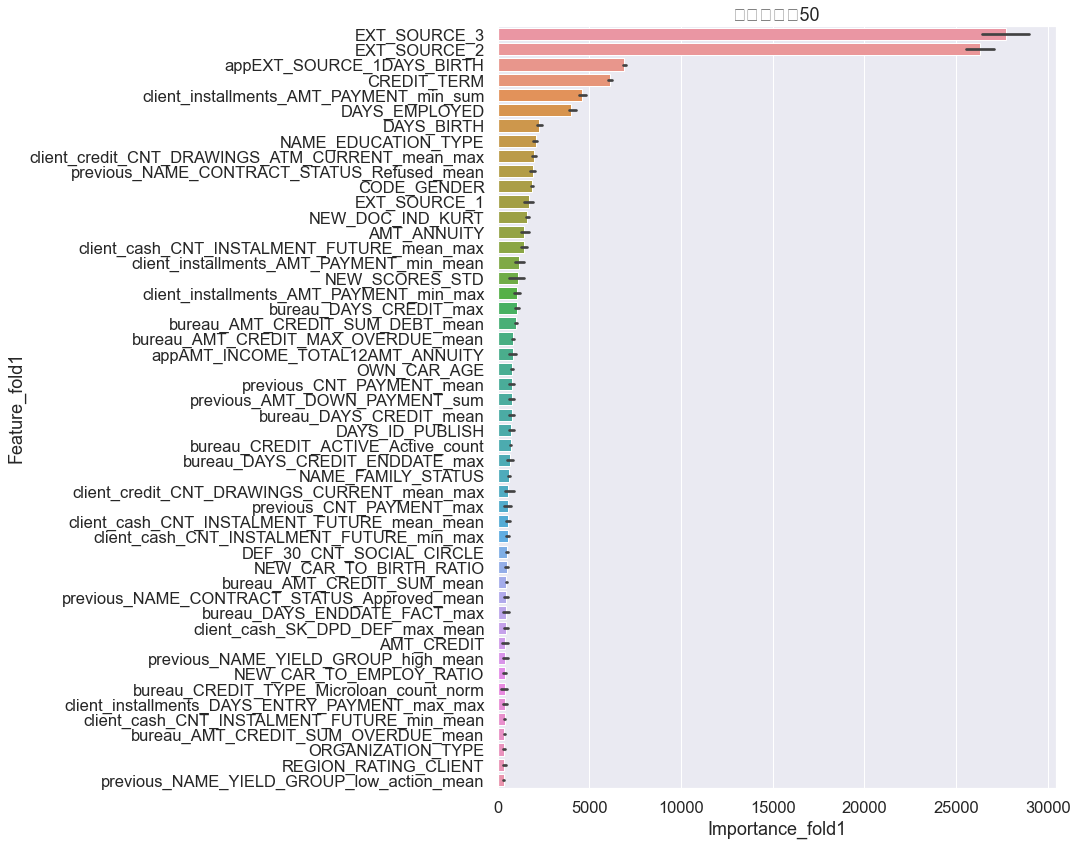

In [36]:
indices2 = feature_importance_plot(feat_df)

In [37]:
sub = application_test[['SK_ID_CURR']].copy()
sub['TARGET'] = preds_test
sub.to_csv('sub.csv', index= False)
# 0.78833

In [49]:
important_list = list(set(indices2.iloc[:200, 0].values.tolist()))
train_df = train_df[important_list]
train_df = pd.concat([train_df, train_y], axis=1, sort=False)
test_df = test_df[important_list]


In [54]:
train_df.drop('TARGET', axis=1, inplace=True)

In [55]:
pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df, train_y, test_df, 5)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[242]	training's auc: 0.819646	training's binary_logloss: 0.225211	valid_1's auc: 0.785673	valid_1's binary_logloss: 0.237565
  score Train : 0.819646   score Valid : 0.785673
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[197]	training's auc: 0.812734	training's binary_logloss: 0.228025	valid_1's auc: 0.791463	valid_1's binary_logloss: 0.235981
  score Train : 0.812734   score Valid : 0.791463
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[270]	training's auc: 0.823187	training's binary_logloss: 0.223871	valid_1's auc: 0.788247	valid_1's binary_logloss: 0.236877
  score Train : 0.823187   score Valid : 0.788247
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[221]	training's auc: 0.817453	training's binary_logloss: 0.225965	valid_1's auc: 0.7838

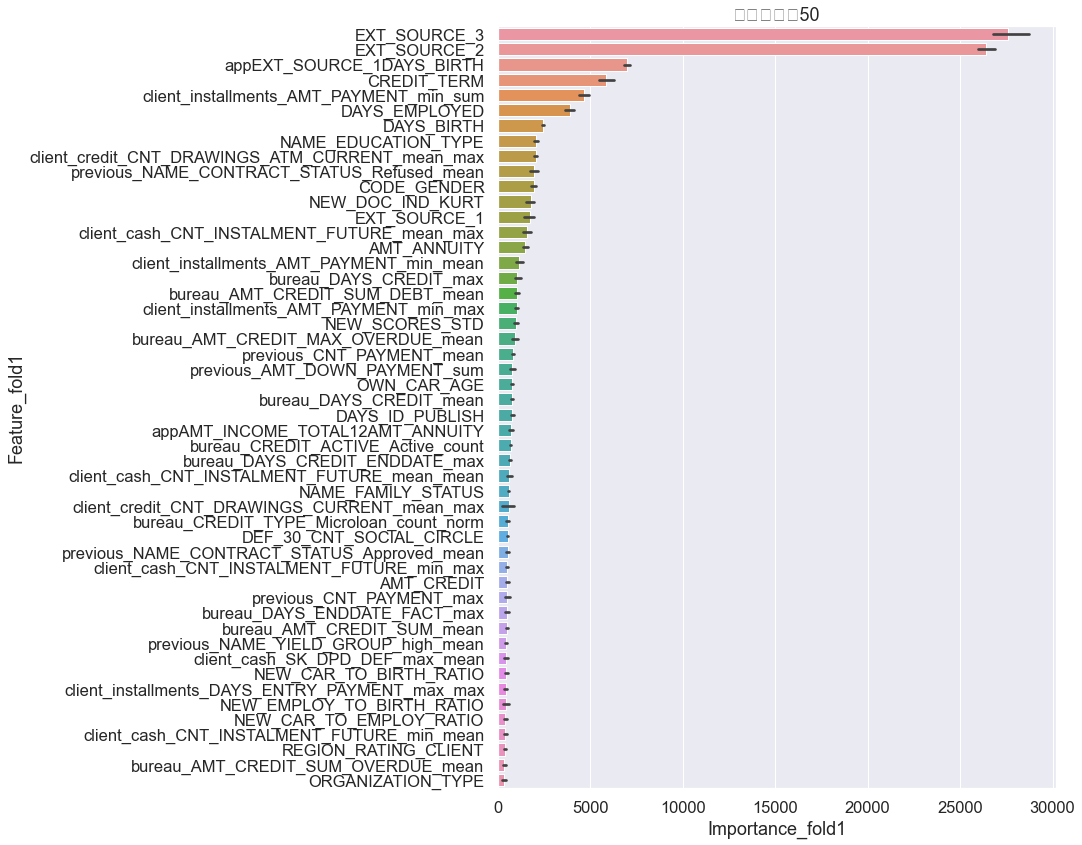

In [56]:
indices3 = feature_importance_plot(feat_df)

In [57]:
important_list = list(set(indices3.iloc[:200, 0].values.tolist()))
train_df_200 = train_df[important_list]
test_df_200 = test_df[important_list]

In [58]:
pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df_200, train_y, test_df_200, 5)

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[155]	training's auc: 0.806812	training's binary_logloss: 0.230109	valid_1's auc: 0.783606	valid_1's binary_logloss: 0.238429
  score Train : 0.806812   score Valid : 0.783606
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[148]	training's auc: 0.805075	training's binary_logloss: 0.230801	valid_1's auc: 0.790248	valid_1's binary_logloss: 0.236341
  score Train : 0.805075   score Valid : 0.790248
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[238]	training's auc: 0.818196	training's binary_logloss: 0.225674	valid_1's auc: 0.787244	valid_1's binary_logloss: 0.237324
  score Train : 0.818196   score Valid : 0.787244
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[210]	training's auc: 0.815389	training's binary_logloss: 0.226694	valid_1's auc: 0.783928	v

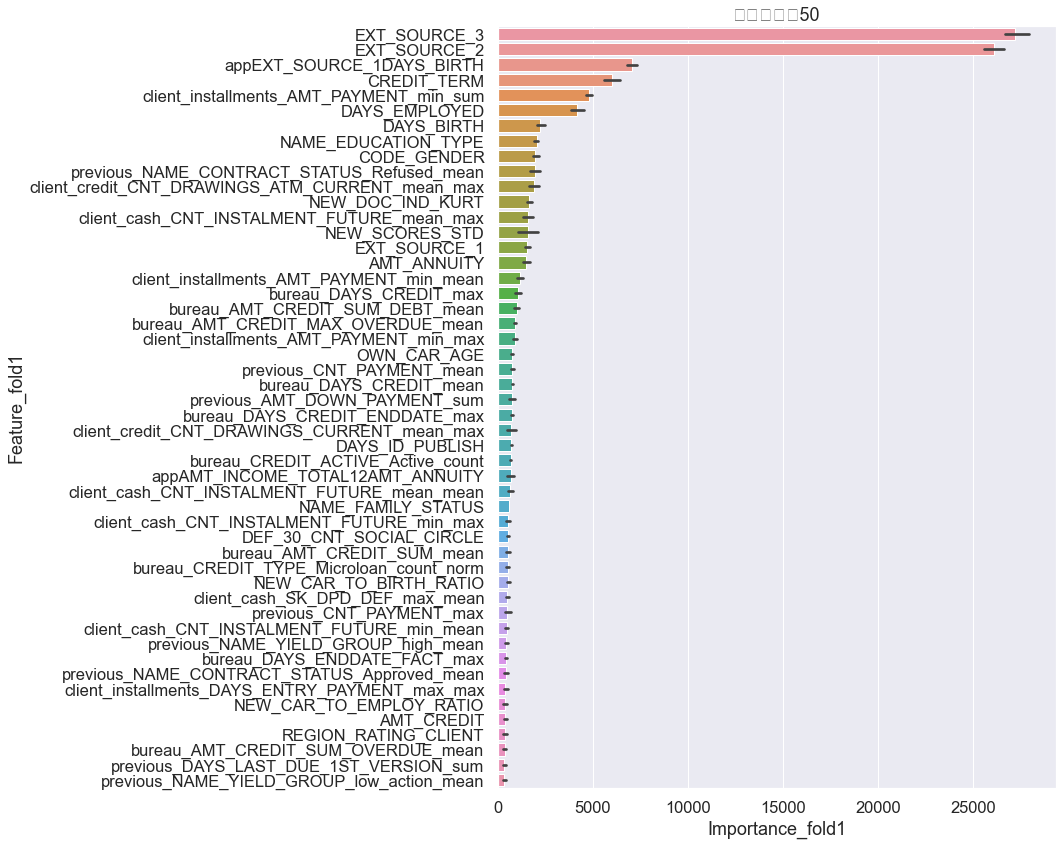

In [59]:
indices4 = feature_importance_plot(feat_df)

In [60]:
important_list = list(set(indices4.iloc[:200, 0].values.tolist()))
train_df = train_df_200[important_list]
train_df = pd.concat([train_df, train_y], axis=1, sort=False)
test_df = test_df_200[important_list]

train_df.to_pickle('../home credit/selected_train.pkl')
test_df.to_pickle('../home credit/selected_test.pkl')

In [61]:
del train_df
del train_y
del test_df
del train_df_200
del test_df_200
del df
del train
del test
gc.collect()

34484

In [45]:
train_ = pd.read_pickle('../home credit/selected_train.pkl')
train_.head()

,OCCUPATION_TYPE,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_min,DAYS_BIRTH,previous_DAYS_FIRST_DUE_sum,CODE_GENDER,NEW_SCORES_STD,client_cash_MONTHS_BALANCE_sum_min,previous_RATE_DOWN_PAYMENT_mean,previous_RATE_DOWN_PAYMENT_min,FLOORSMAX_AVG,bureau_AMT_CREDIT_SUM_DEBT_max,client_cash_MONTHS_BALANCE_max_min,previous_HOUR_APPR_PROCESS_START_mean,FLAG_WORK_PHONE,previous_NAME_CONTRACT_STATUS_Refused_mean,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Active_count,client_credit_CNT_DRAWINGS_CURRENT_mean_min,BASEMENTAREA_AVG,client_cash_NAME_CONTRACT_STATUS_Completed_mean_mean,client_installments_NUM_INSTALMENT_VERSION_sum_sum,ORGANIZATION_TYPE,previous_AMT_CREDIT_sum,NEW_LIVE_IND_STD,bureau_AMT_CREDIT_SUM_min,client_cash_SK_DPD_DEF_sum_sum,client_cash_MONTHS_BALANCE_min_min,client_cash_CNT_INSTALMENT_FUTURE_mean_sum,previous_CNT_PAYMENT_mean,client_cash_CNT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_min_max,EXT_SOURCE_3,client_cash_CNT_INSTALMENT_FUTURE_max_min,client_bureau_balance_STATUS_0_count_max,NEW_INC_PER_CHLD,previous_DAYS_LAST_DUE_1ST_VERSION_max,client_installments_AMT_PAYMENT_max_sum,client_credit_AMT_BALANCE_mean_max,client_credit_AMT_PAYMENT_CURRENT_sum_mean,previous_WEEKDAY_APPR_PROCESS_START_MONDAY_mean,bureau_AMT_CREDIT_SUM_DEBT_mean,client_credit_CNT_DRAWINGS_POS_CURRENT_mean_min,previous_AMT_DOWN_PAYMENT_max,NEW_PHONE_TO_BIRTH_RATIO,client_installments_AMT_INSTALMENT_sum_mean,previous_RATE_DOWN_PAYMENT_sum,client_installments_DAYS_ENTRY_PAYMENT_sum_min,client_cash_SK_DPD_DEF_sum_mean,client_cash_MONTHS_BALANCE_mean_min,client_credit_AMT_INST_MIN_REGULARITY_max_max,client_cash_SK_DPD_DEF_mean_max,client_cash_NAME_CONTRACT_STATUS_Active_sum_mean,client_cash_MONTHS_BALANCE_mean_sum,DAYS_REGISTRATION,client_installments_AMT_PAYMENT_mean_mean,client_installments_AMT_INSTALMENT_max_sum,NEW_INC_BY_ORG,bureau_DAYS_CREDIT_ENDDATE_min,previous_AMT_GOODS_PRICE_mean,previous_AMT_CREDIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_mean,client_installments_AMT_PAYMENT_sum_mean,previous_CODE_REJECT_REASON_XAP_mean,previous_RATE_DOWN_PAYMENT_max,client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_sum,client_cash_CNT_INSTALMENT_FUTURE_min_mean,previous_DAYS_FIRST_DUE_max,client_installments_AMT_PAYMENT_min_sum,client_credit_AMT_RECEIVABLE_PRINCIPAL_mean_max,previous_AMT_DOWN_PAYMENT_sum,EXT_SOURCE_1,bureau_AMT_CREDIT_MAX_OVERDUE_mean,AMT_REQ_CREDIT_BUREAU_QRT,client_installments_AMT_PAYMENT_mean_min,client_cash_SK_DPD_mean_min,client_credit_AMT_BALANCE_min_sum,client_installments_AMT_INSTALMENT_sum_sum,client_cash_MONTHS_BALANCE_max_max,previous_NAME_CLIENT_TYPE_Repeater_mean,client_credit_AMT_CREDIT_LIMIT_ACTUAL_mean_max,client_installments_NUM_INSTALMENT_NUMBER_max_min,bureau_AMT_CREDIT_SUM_LIMIT_max,client_cash_MONTHS_BALANCE_mean_mean,previous_CODE_REJECT_REASON_SCO_mean,client_cash_CNT_INSTALMENT_max_max,previous_NAME_PRODUCT_TYPE_walkin_mean,NEW_CAR_TO_EMPLOY_RATIO,client_installments_DAYS_ENTRY_PAYMENT_min_min,client_credit_AMT_RECEIVABLE_PRINCIPAL_min_max,previous_NAME_CLIENT_TYPE_Refreshed_mean,client_cash_CNT_INSTALMENT_FUTURE_mean_min,client_credit_AMT_RECIVABLE_mean_max,bureau_CREDIT_TYPE_Mortgage_count_norm,previous_AMT_CREDIT_min,NAME_CONTRACT_TYPE,client_bureau_balance_STATUS_0_count_mean,client_installments_DAYS_ENTRY_PAYMENT_max_max,ENTRANCES_AVG,REG_CITY_NOT_LIVE_CITY,previous_AMT_ANNUITY_mean,client_bureau_balance_MONTHS_BALANCE_count_min,bureau_DAYS_CREDIT_mean,client_cash_CNT_INSTALMENT_FUTURE_sum_min,client_cash_MONTHS_BALANCE_min_mean,REGION_RATING_CLIENT,client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_max,client_credit_AMT_CREDIT_LIMIT_ACTUAL_mean_min,DAYS_LAST_PHONE_CHANGE,client_installments_NUM_INSTALMENT_VERSION_max_sum,previous_NAME_YIELD_GROUP_high_sum,bureau_DAYS_CREDIT_UPDATE_max,previous_NAME_PAYMENT_TYPE_XNA_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_mean,previous_CODE_REJECT_REASON_HC_mean,previous_DAYS_LAST_DUE_sum,previous_AMT_DOWN_PAYMENT_mean,client_installments_AMT_INSTALMENT_max_min,previo

# ラグ特徴量化をする(できるかな、、、。)

# previous_train（前半）

In [139]:
train = pd.read_pickle('../home credit/selected_train.pkl')
test = pd.read_pickle('../home credit/selected_test.pkl')

In [140]:
previous = convert_types(previous_application, print_info=True)
previous.head()

Original Memory Usage: 0.32 gb.
New Memory Usage: 0.32 gb.
(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,True,0.0,0.182861,0.867188,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,True,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,True,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,True,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,True,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


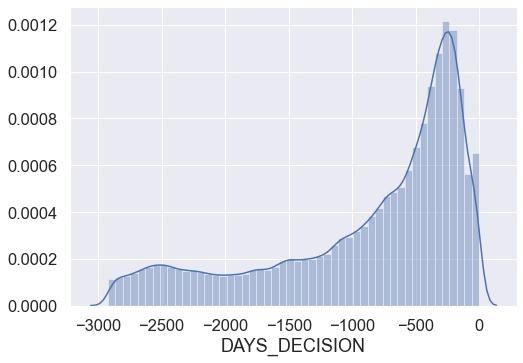

In [141]:
sns.distplot(previous['DAYS_DECISION'])

In [142]:
def make_lag_feature(df, df_name, n, agg_feature, lag_time_feature, train, test):
    df = df[df[lag_time_feature]/-365 < n]
    df_agg = agg_numeric(df, agg_feature, df_name+str(n))
    df_counts = agg_categorical(df, agg_feature, 'previous'+str(n))
    
    train = train.merge(df_counts, on = agg_feature, how = 'left')
    train = train.merge(df_agg, on = agg_feature, how = 'left')

    test = test.merge(df_counts, on =agg_feature, how = 'left')
    test = test.merge(df_agg, on = agg_feature, how = 'left')

    gc.enable()
    del df, df_agg, df_counts
    gc.collect()

    train, test = remove_missing_columns(train, test)
    print(train.shape, test.shape)
    return train, test

In [143]:
train, test = make_lag_feature(previous, 'previous', 10, 'SK_ID_CURR', 'DAYS_DECISION', train, test)
train, test = make_lag_feature(previous, 'previous', 5, 'SK_ID_CURR', 'DAYS_DECISION', train, test)
train, test = make_lag_feature(previous, 'previous', 3, 'SK_ID_CURR', 'DAYS_DECISION', train, test)
'''train, test = make_lag_feature(previous, 1, 'SK_ID_CURR', 'DAYS_DECISION', train, test)
train, test = make_lag_feature(previous, 6/12, 'SK_ID_CURR', 'DAYS_DECISION', train, test)
train, test = make_lag_feature(previous, 3/12, 'SK_ID_CURR', 'DAYS_DECISION', train, test)'''

There are 6 columns with greater than 90% missing values.
(307511, 560) (48744, 559)
There are 6 columns with greater than 90% missing values.
(307511, 919) (48744, 918)
There are 6 columns with greater than 90% missing values.
(307511, 1278) (48744, 1277)


"train, test = make_lag_feature(previous, 1, 'SK_ID_CURR', 'DAYS_DECISION', train, test)\ntrain, test = make_lag_feature(previous, 6/12, 'SK_ID_CURR', 'DAYS_DECISION', train, test)\ntrain, test = make_lag_feature(previous, 3/12, 'SK_ID_CURR', 'DAYS_DECISION', train, test)"

In [144]:
train.to_pickle('prev_lag_long_train.pkl')
test.to_pickle('prev_lag_long_test.pkl')

In [145]:
del train
del test
gc.collect()

40

In [146]:
train_df = pd.read_pickle('../home credit/prev_lag_long_train.pkl')
test_df = pd.read_pickle('../home credit/prev_lag_long_test.pkl')

for c in train_df.columns:
    if train_df[c].dtypes == 'bool':
        train_df[c] = train_df[c].astype(np.int8)
        
for c in test_df.columns:
    if test_df[c].dtypes == 'bool':
        test_df[c] = test_df[c].astype(np.int8)
        
train_y = train_df['TARGET']
train_df.drop('TARGET', axis=1, inplace=True)

num_f, cat_f = num_cat(train_df)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df[cat_f] = train_df[cat_f].fillna('nan')
test_df[cat_f] = test_df[cat_f].fillna('nan')

df = pd.concat([train_df, test_df], sort=False)
for cat in cat_f:
    df[cat] = le.fit_transform(df[cat])
train_df = df[:len(train_df)]
test_df = df[len(train_df):]
train_df = rename_data(train_df)
test_df = rename_data(test_df)
del df
gc.collect()

0

In [148]:
model = lgb.LGBMClassifier(
            nthread=4,
            n_estimators=1000,
            learning_rate=0.1,
            maxdepth=3,
            num_leaves=12,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, 
            importance_type='gain')

pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df, train_y, test_df, 5)

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[160]	training's auc: 0.808894	training's binary_logloss: 0.229399	valid_1's auc: 0.783673	valid_1's binary_logloss: 0.238268
  score Train : 0.808894   score Valid : 0.783673
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[161]	training's auc: 0.808505	training's binary_logloss: 0.229661	valid_1's auc: 0.790339	valid_1's binary_logloss: 0.236442
  score Train : 0.808505   score Valid : 0.790339
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[163]	training's auc: 0.809554	training's binary_logloss: 0.22907	valid_1's auc: 0.78561	valid_1's binary_logloss: 0.237991
  score Train : 0.809554   score Valid : 0.785610
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[208]	training's auc: 0.816946	training's binary_logloss: 0.226274	valid_1's auc: 0.782823	val

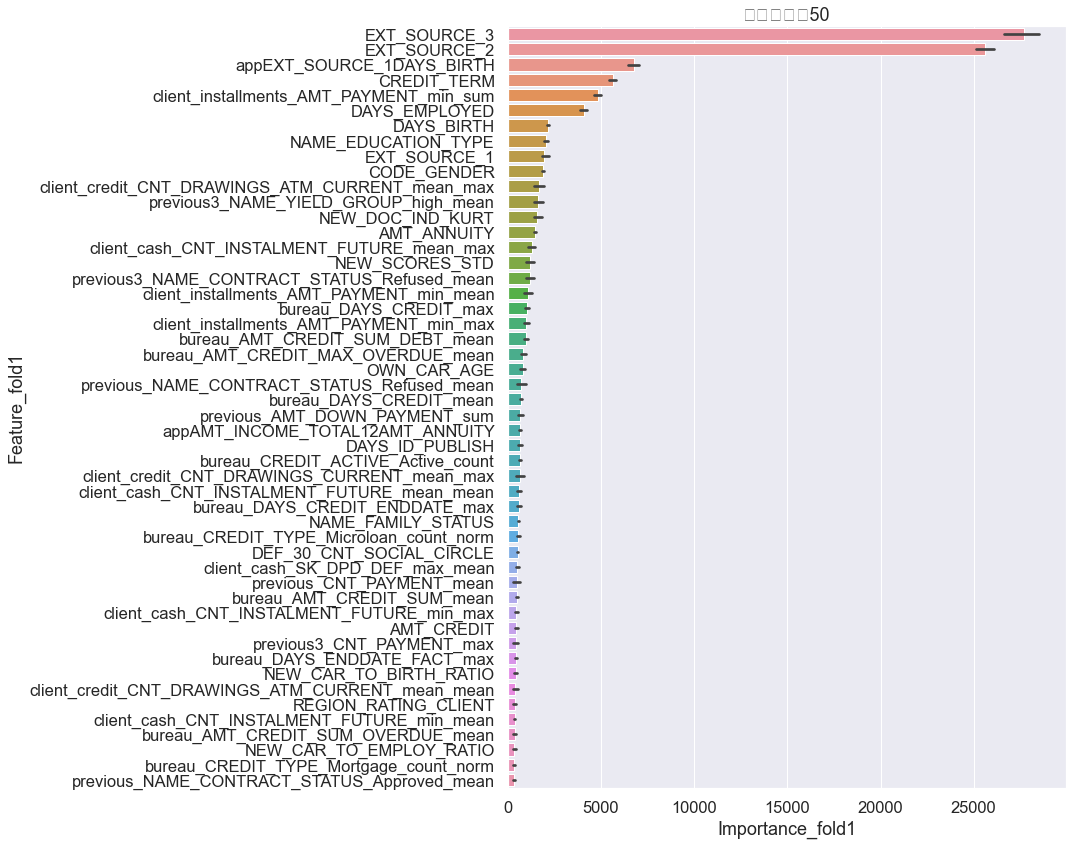

In [149]:
indices = feature_importance_plot(feat_df)

In [150]:
important_list = list(set(indices.iloc[:200, 0].values.tolist()))
if 'SK_ID_CURR' not in important_list:
    important_list.append('SK_ID_CURR')
train_df = train_df[important_list]
train_df = pd.concat([train_df, train_y], axis=1, sort=False)
test_df= test_df[important_list]

In [153]:
train_df.to_pickle('prev_lag_recent_train_df.pkl')
test_df.to_pickle('prev_lag_recent_test_df.pkl')

In [154]:
del train_df
del test_df
gc.collect()

11523

# previous_lag後半

In [155]:
train = pd.read_pickle('../home credit/prev_lag_recent_train_df.pkl')
test = pd.read_pickle('../home credit/prev_lag_recent_test_df.pkl')

In [156]:
train, test = make_lag_feature(previous, 'previous', 1, 'SK_ID_CURR', 'DAYS_DECISION', train, test)
train, test = make_lag_feature(previous, 'previous', 6/12, 'SK_ID_CURR', 'DAYS_DECISION', train, test)
train, test = make_lag_feature(previous, 'previous', 3/12, 'SK_ID_CURR', 'DAYS_DECISION', train, test)

There are 6 columns with greater than 90% missing values.
(307511, 553) (48744, 552)
There are 6 columns with greater than 90% missing values.
(307511, 898) (48744, 897)
There are 39 columns with greater than 90% missing values.
(307511, 1202) (48744, 1201)


In [157]:
train.to_pickle('prev_lag_recent_train.pkl')
test.to_pickle('prev_lag_recent_test.pkl')

In [158]:
del train
del test
gc.collect()

40

In [159]:
train_df = pd.read_pickle('../home credit/prev_lag_recent_train.pkl')
test_df = pd.read_pickle('../home credit/prev_lag_recent_test.pkl')

for c in train_df.columns:
    if train_df[c].dtypes == 'bool':
        train_df[c] = train_df[c].astype(np.int8)
        
for c in test_df.columns:
    if test_df[c].dtypes == 'bool':
        test_df[c] = test_df[c].astype(np.int8)

train_y = train_df['TARGET']
train_df.drop('TARGET', axis=1, inplace=True)

train_df = rename_data(train_df)
test_df = rename_data(test_df)

pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df, train_y, test_df, 5)

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[183]	training's auc: 0.811665	training's binary_logloss: 0.228256	valid_1's auc: 0.785873	valid_1's binary_logloss: 0.237646
  score Train : 0.811665   score Valid : 0.785873
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[191]	training's auc: 0.812317	training's binary_logloss: 0.228009	valid_1's auc: 0.791739	valid_1's binary_logloss: 0.235936
  score Train : 0.812317   score Valid : 0.791739
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[172]	training's auc: 0.810329	training's binary_logloss: 0.228842	valid_1's auc: 0.785643	valid_1's binary_logloss: 0.237891
  score Train : 0.810329   score Valid : 0.785643
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[168]	training's auc: 0.81046	training's binary_logloss: 0.228684	valid_1's auc: 0.782871	va

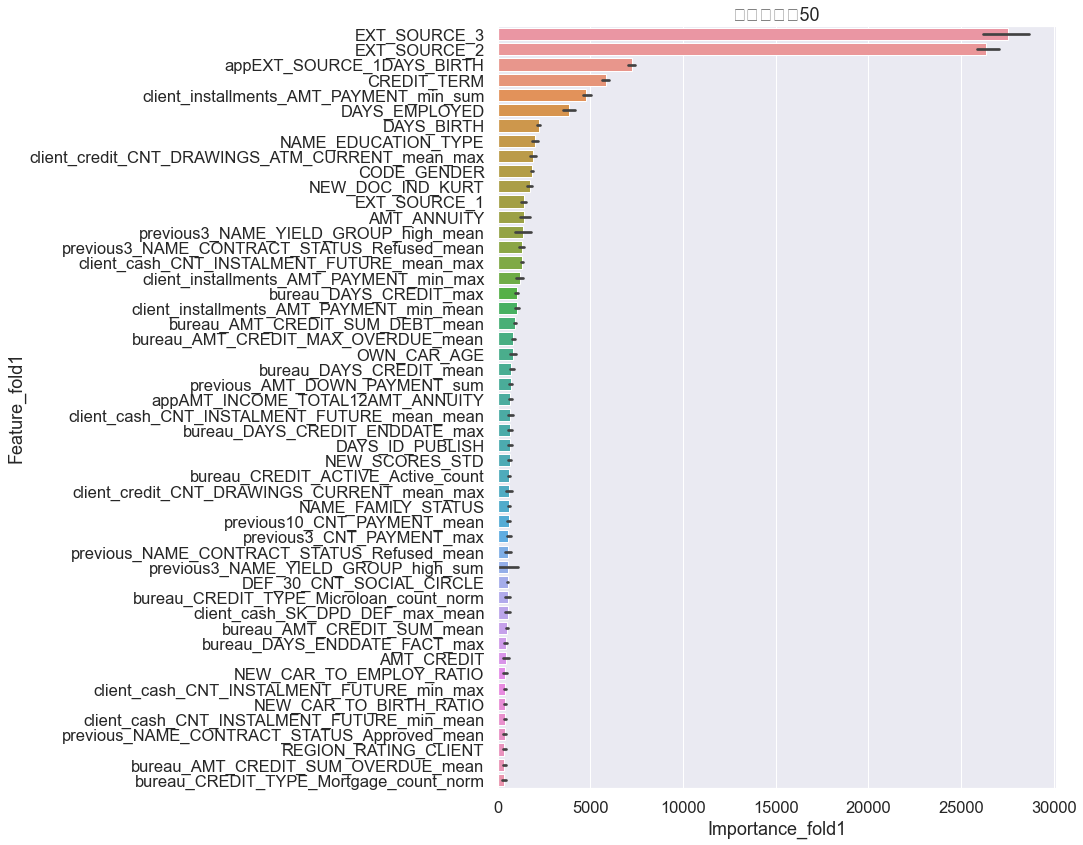

In [160]:
indices = feature_importance_plot(feat_df)
important_list = list(set(indices.iloc[:200, 0].values.tolist()))
if 'SK_ID_CURR' not in important_list:
    important_list.append('SK_ID_CURR')
train_df = train_df[important_list]
train_df = pd.concat([train_df, train_y], axis=1, sort=False)
test_df= test_df[important_list]

In [161]:
train_df.to_pickle('prev_lag_recent_train_df.pkl')
test_df.to_pickle('prev_lag_recent_test_df.pkl')

# そのほかのテーブル

In [162]:
def lag_aggregate_client(df, n , group_vars, df_names, lag_time_feature, day_or_month):
    if day_or_month=='days':
        df = df[df[lag_time_feature]/-365 < n]
    elif day_or_month=='month':
        df = df[df[lag_time_feature]/-12 < n]

    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0]+str(n))
    
    if any(df.dtypes == 'object'):
        # SK_ID_PREVごとに集計
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0]+str(n))

        #数値変数、カテゴリ変数ごとに集計して、くっつけたもの
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        #df_by_loanにSK_ID_CURRをくっつける
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # SK_ID_PREVを削除
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # SK_ID_CURRごとに集計
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1]+str(n))

        
    # カテゴリ変数がない場合は上記を一部省略
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1]+str(n))
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()
    
    print(df_by_client.shape)
    return df_by_client

# 2回集計をしているので、ラグ特徴量を作る際には注意が必要

# POS_cash_balance

In [163]:
train = pd.read_pickle('../home credit/prev_lag_recent_train_df.pkl')
test = pd.read_pickle('../home credit/prev_lag_recent_test_df.pkl')

In [164]:
cash = convert_types(POS_CASH_balance, print_info=True)
cash_by_client_10 = lag_aggregate_client(cash, 10, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'MONTHS_BALANCE', 'month')
cash_by_client_5 = lag_aggregate_client(cash, 5, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'MONTHS_BALANCE', 'month')
cash_by_client_3 = lag_aggregate_client(cash, 3, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'MONTHS_BALANCE', 'month')
cash_by_client_1 = lag_aggregate_client(cash, 1, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'MONTHS_BALANCE', 'month')
cash_by_client_half = lag_aggregate_client(cash, 6/12, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'MONTHS_BALANCE', 'month')
cash_by_client_quarter = lag_aggregate_client(cash, 3/12, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'MONTHS_BALANCE', 'month')

Original Memory Usage: 0.25 gb.
New Memory Usage: 0.25 gb.
(10001358, 8)
(337252, 165)
(320405, 165)
(301464, 165)
(233396, 152)
(182471, 150)
(146892, 146)


In [165]:
train = train.merge(cash_by_client_10, on='SK_ID_CURR', how='left').merge(cash_by_client_5, on='SK_ID_CURR', how='left').merge(cash_by_client_3, on='SK_ID_CURR', how='left').merge(cash_by_client_1, on='SK_ID_CURR', how='left').merge(cash_by_client_half, on='SK_ID_CURR', how='left').merge(cash_by_client_quarter, on='SK_ID_CURR', how='left')
test = test.merge(cash_by_client_10, on='SK_ID_CURR', how='left').merge(cash_by_client_5, on='SK_ID_CURR', how='left').merge(cash_by_client_3, on='SK_ID_CURR', how='left').merge(cash_by_client_1, on='SK_ID_CURR', how='left').merge(cash_by_client_half, on='SK_ID_CURR', how='left').merge(cash_by_client_quarter, on='SK_ID_CURR', how='left')
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


In [166]:
train.to_pickle('cash_lag_train.pkl')
test.to_pickle('cash_lag_test.pkl')

In [167]:
del train
del test
del cash_by_client_10
del cash_by_client_5
del cash_by_client_3
del cash_by_client_1
del cash_by_client_half
del cash_by_client_quarter
gc.collect()

40

In [183]:
train_df = pd.read_pickle('../home credit/cash_lag_train.pkl')
test_df = pd.read_pickle('../home credit/cash_lag_test.pkl')

for c in train_df.columns:
    if train_df[c].dtypes == 'bool':
        train_df[c] = train_df[c].astype(np.int8)
        
for c in test_df.columns:
    if test_df[c].dtypes == 'bool':
        test_df[c] = test_df[c].astype(np.int8)
        
train_y = train_df['TARGET']
train_df.drop('TARGET', axis=1, inplace=True)

train_df = rename_data(train_df)
test_df = rename_data(test_df)

pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df, train_y, test_df, 5)

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[204]	training's auc: 0.815504	training's binary_logloss: 0.226783	valid_1's auc: 0.787335	valid_1's binary_logloss: 0.237224
  score Train : 0.815504   score Valid : 0.787335
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[152]	training's auc: 0.807704	training's binary_logloss: 0.229765	valid_1's auc: 0.791405	valid_1's binary_logloss: 0.23615
  score Train : 0.807704   score Valid : 0.791405
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[199]	training's auc: 0.814704	training's binary_logloss: 0.226905	valid_1's auc: 0.787752	valid_1's binary_logloss: 0.237281
  score Train : 0.814704   score Valid : 0.787752
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[220]	training's auc: 0.818311	training's binary_logloss: 0.225483	valid_1's auc: 0.78462	val

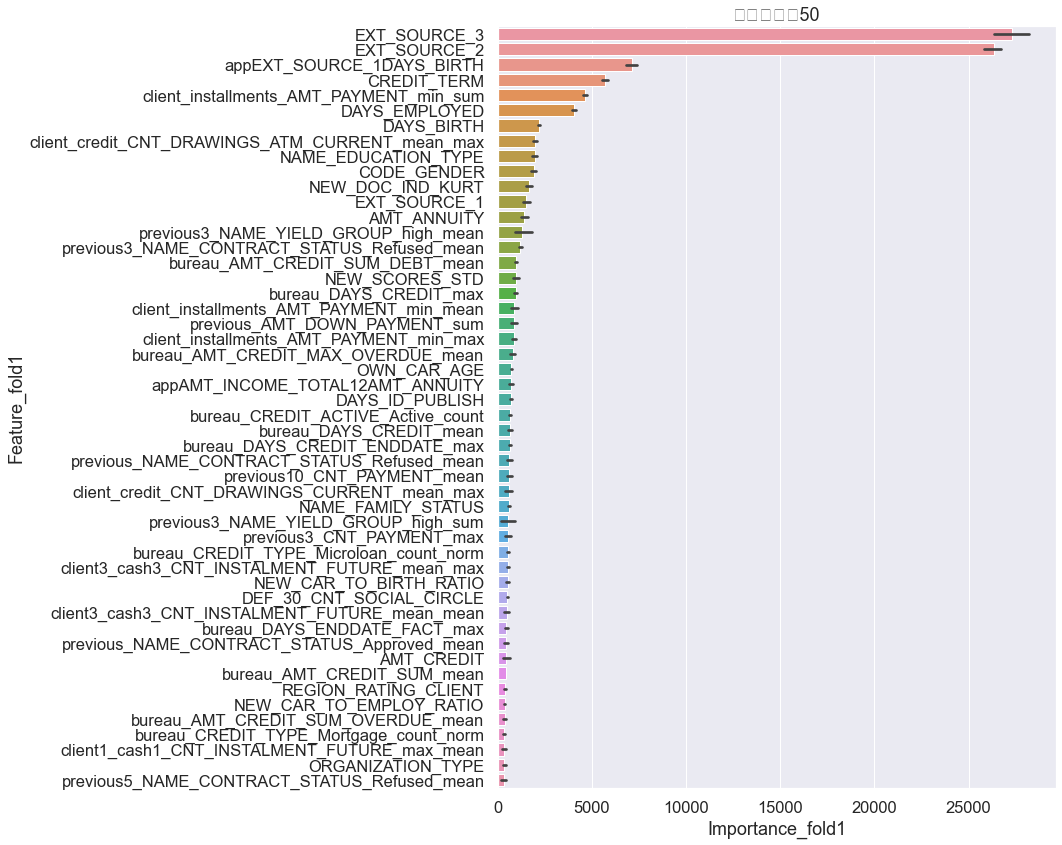

In [184]:
indices = feature_importance_plot(feat_df)
important_list = list(set(indices.iloc[:200, 0].values.tolist()))
if 'SK_ID_CURR' not in important_list:
    important_list.append('SK_ID_CURR')
train_df = train_df[important_list]
train_df = pd.concat([train_df, train_y], axis=1, sort=False)
test_df= test_df[important_list]

In [185]:
train_df.to_pickle('cash_lag_train_df.pkl')
test_df.to_pickle('cash_lag_test_df.pkl')

In [186]:
del train_df
del test_df
gc.collect()

11527

# credit(前半)

In [187]:
train = pd.read_pickle('../home credit/cash_lag_train_df.pkl')
test = pd.read_pickle('../home credit/cash_lag_test_df.pkl')

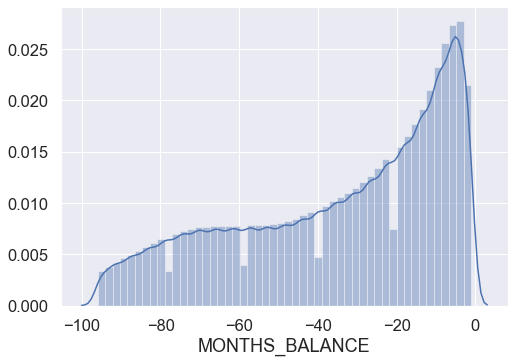

In [188]:
sns.distplot(credit_card_balance['MONTHS_BALANCE'])

In [189]:
credit = convert_types(credit_card_balance, print_info = True)
credit_by_client_10 = lag_aggregate_client(credit, 10, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'MONTHS_BALANCE', 'month')
credit_by_client_5 = lag_aggregate_client(credit, 5, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'MONTHS_BALANCE', 'month')
credit_by_client_3 = lag_aggregate_client(credit, 3, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'MONTHS_BALANCE', 'month')

Original Memory Usage: 0.3 gb.
New Memory Usage: 0.3 gb.
(3840312, 23)
(103558, 381)
(103558, 374)
(103558, 368)


In [190]:
train = train.merge(credit_by_client_10, on='SK_ID_CURR', how='left').merge(credit_by_client_5, on='SK_ID_CURR', how='left').merge(credit_by_client_3, on='SK_ID_CURR', how='left')
test = test.merge(credit_by_client_10, on='SK_ID_CURR', how='left').merge(credit_by_client_5, on='SK_ID_CURR', how='left').merge(credit_by_client_3, on='SK_ID_CURR', how='left')
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


In [191]:
train.to_pickle('credit_lag_l_train.pkl')
test.to_pickle('credit_lag_l_test.pkl')

In [192]:
del train
del test
del credit_by_client_10
del credit_by_client_5
del credit_by_client_3
gc.collect()

40

In [193]:
train_df = pd.read_pickle('../home credit/credit_lag_l_train.pkl')
test_df = pd.read_pickle('../home credit/credit_lag_l_test.pkl')

for c in train_df.columns:
    if train_df[c].dtypes == 'bool':
        train_df[c] = train_df[c].astype(np.int8)
        
for c in test_df.columns:
    if test_df[c].dtypes == 'bool':
        test_df[c] = test_df[c].astype(np.int8)
        
train_y = train_df['TARGET']
train_df.drop('TARGET', axis=1, inplace=True)

train_df = rename_data(train_df)
test_df = rename_data(test_df)

pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df, train_y, test_df, 5)

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[153]	training's auc: 0.80798	training's binary_logloss: 0.229664	valid_1's auc: 0.78586	valid_1's binary_logloss: 0.237707
  score Train : 0.807980   score Valid : 0.785860
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[180]	training's auc: 0.811153	training's binary_logloss: 0.228299	valid_1's auc: 0.792365	valid_1's binary_logloss: 0.235626
  score Train : 0.811153   score Valid : 0.792365
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[208]	training's auc: 0.815331	training's binary_logloss: 0.226665	valid_1's auc: 0.78725	valid_1's binary_logloss: 0.237227
  score Train : 0.815331   score Valid : 0.787250
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[188]	training's auc: 0.813767	training's binary_logloss: 0.22719	valid_1's auc: 0.784922	valid

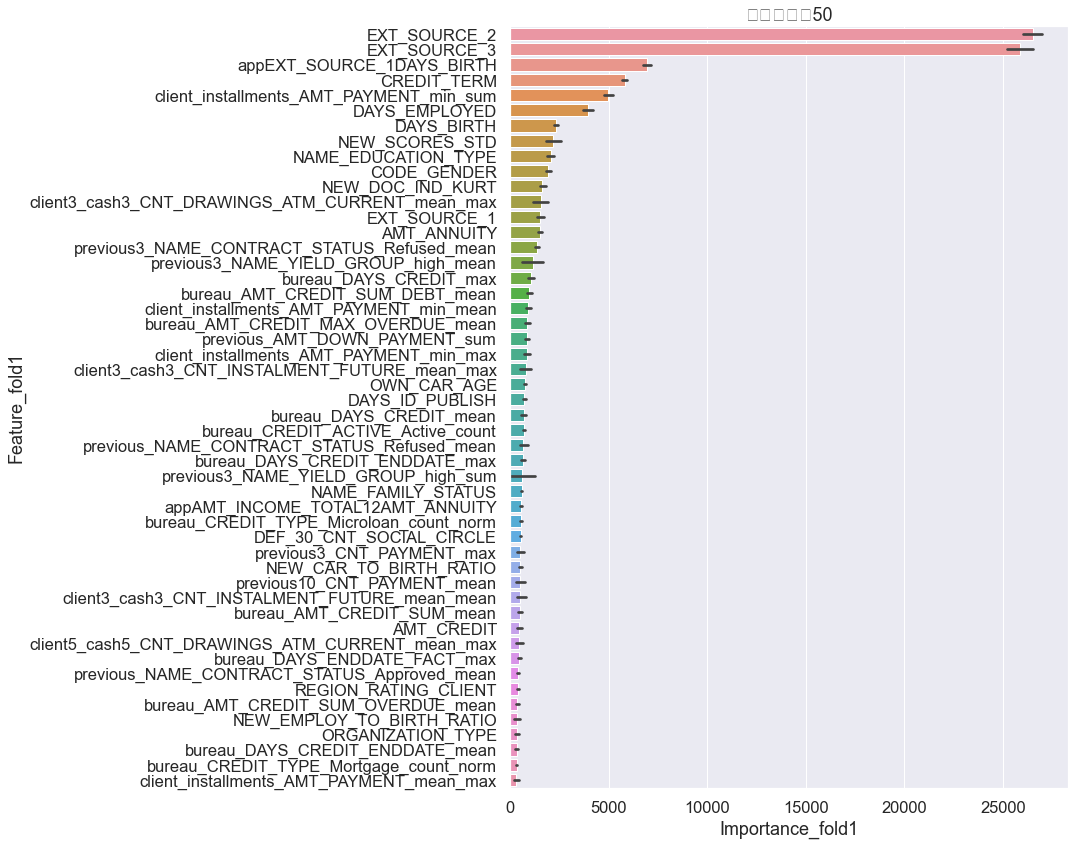

In [194]:
indices = feature_importance_plot(feat_df)
important_list = list(set(indices.iloc[:200, 0].values.tolist()))
if 'SK_ID_CURR' not in important_list:
    important_list.append('SK_ID_CURR')
train_df = train_df[important_list]
train_df = pd.concat([train_df, train_y], axis=1, sort=False)
test_df= test_df[important_list]

In [195]:
train_df.to_pickle('credit_lag_l_train_df.pkl')
test_df.to_pickle('credit_lag_l_test_df.pkl')

In [196]:
del train_df
del test_df
gc.collect()

11449

# credit(後半)

In [197]:
train = pd.read_pickle('../home credit/credit_lag_l_train_df.pkl')
test = pd.read_pickle('../home credit/credit_lag_l_test_df.pkl')

In [198]:
credit = convert_types(credit_card_balance, print_info = True)
credit_by_client_1 = lag_aggregate_client(credit, 1, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'MONTHS_BALANCE', 'month')
credit_by_client_half = lag_aggregate_client(credit, 6/12, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'MONTHS_BALANCE', 'month')
credit_by_client_quarter = lag_aggregate_client(credit, 3/12, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'MONTHS_BALANCE', 'month')

Original Memory Usage: 0.3 gb.
New Memory Usage: 0.3 gb.
(3840312, 23)
(103557, 365)
(103556, 363)
(94385, 363)


In [199]:
train = train.merge(credit_by_client_1, on='SK_ID_CURR', how='left').merge(credit_by_client_half, on='SK_ID_CURR', how='left').merge(credit_by_client_quarter, on='SK_ID_CURR', how='left')
test = test.merge(credit_by_client_1, on='SK_ID_CURR', how='left').merge(credit_by_client_half, on='SK_ID_CURR', how='left').merge(credit_by_client_quarter, on='SK_ID_CURR', how='left')
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


In [200]:
train.to_pickle('credit_lag_r_train.pkl')
test.to_pickle('credit_lag_r_test.pkl')

In [201]:
del train
del test
del credit_by_client_1
del credit_by_client_half
del credit_by_client_quarter
del credit
gc.collect()

40

In [202]:
train_df = pd.read_pickle('../home credit/credit_lag_r_train.pkl')
test_df = pd.read_pickle('../home credit/credit_lag_r_test.pkl')

for c in train_df.columns:
    if train_df[c].dtypes == 'bool':
        train_df[c] = train_df[c].astype(np.int8)
        
for c in test_df.columns:
    if test_df[c].dtypes == 'bool':
        test_df[c] = test_df[c].astype(np.int8)
        
train_y = train_df['TARGET']
train_df.drop('TARGET', axis=1, inplace=True)

train_df = rename_data(train_df)
test_df = rename_data(test_df)

pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df, train_y, test_df, 5)

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[201]	training's auc: 0.814616	training's binary_logloss: 0.226918	valid_1's auc: 0.787996	valid_1's binary_logloss: 0.236869
  score Train : 0.814616   score Valid : 0.787996
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[151]	training's auc: 0.807289	training's binary_logloss: 0.229744	valid_1's auc: 0.792148	valid_1's binary_logloss: 0.235835
  score Train : 0.807289   score Valid : 0.792148
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[214]	training's auc: 0.816775	training's binary_logloss: 0.225977	valid_1's auc: 0.787675	valid_1's binary_logloss: 0.237094
  score Train : 0.816775   score Valid : 0.787675
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[212]	training's auc: 0.817175	training's binary_logloss: 0.225853	valid_1's auc: 0.784374	v

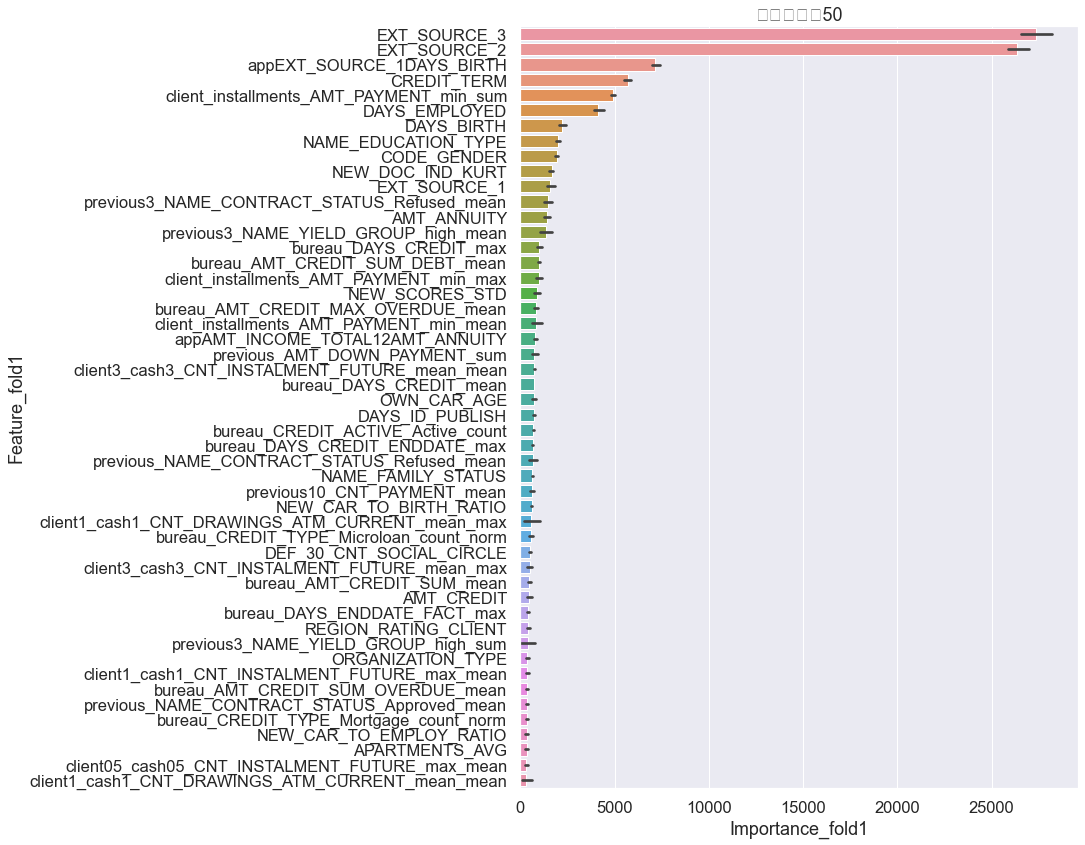

In [203]:
indices = feature_importance_plot(feat_df)
important_list = list(set(indices.iloc[:200, 0].values.tolist()))
if 'SK_ID_CURR' not in important_list:
    important_list.append('SK_ID_CURR')
train_df = train_df[important_list]
train_df = pd.concat([train_df, train_y], axis=1, sort=False)
test_df= test_df[important_list]

In [204]:
train_df.to_pickle('credit_lag_r_train_df.pkl')
test_df.to_pickle('credit_lag_r_test_df.pkl')

In [205]:
del train_df
del test_df
gc.collect()

11464

# installments

In [212]:
train = pd.read_pickle('../home credit/credit_lag_r_train_df.pkl')
test = pd.read_pickle('../home credit/credit_lag_r_test_df.pkl')

In [213]:
test = pd.read_pickle('../home credit/credit_lag_r_test_df.pkl')

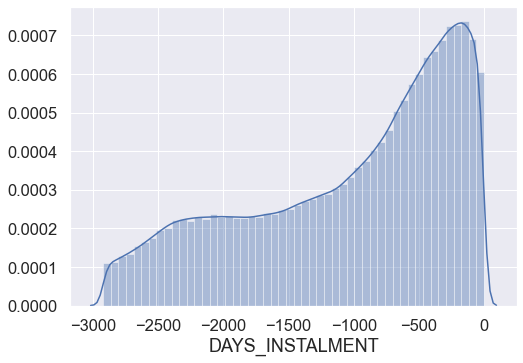

In [214]:
sns.distplot(installments_payments['DAYS_INSTALMENT'])

In [215]:
installments = convert_types(installments_payments, print_info = True)
installments['entry-installment'] = (installments["DAYS_INSTALMENT"] - installments["DAYS_ENTRY_PAYMENT"]).apply(lambda x: 1 if x >= 0 else 0) 

Original Memory Usage: 0.44 gb.
New Memory Usage: 0.34 gb.
(13605401, 9)


In [216]:
installments_by_client_10 = lag_aggregate_client(installments, 10, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'DAYS_INSTALMENT', 'days')
installments_by_client_5 = lag_aggregate_client(installments, 5, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'DAYS_INSTALMENT', 'days')
installments_by_client_3 = lag_aggregate_client(installments, 3, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'DAYS_INSTALMENT', 'days')
installments_by_client_1 = lag_aggregate_client(installments, 1, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'DAYS_INSTALMENT', 'days')
installments_by_client_half = lag_aggregate_client(installments, 6/12, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'DAYS_INSTALMENT', 'days')
installments_by_client_quarter = lag_aggregate_client(installments, 3/12, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'], 'DAYS_INSTALMENT', 'days')

(339587, 122)
(325837, 122)
(308623, 122)
(252579, 122)
(211804, 122)
(186180, 122)


In [218]:
train = train.merge(installments_by_client_10, on='SK_ID_CURR', how='left').merge(installments_by_client_5, on='SK_ID_CURR', how='left').merge(installments_by_client_3, on='SK_ID_CURR', how='left').merge(installments_by_client_1, on='SK_ID_CURR', how='left').merge(installments_by_client_half, on='SK_ID_CURR', how='left').merge(installments_by_client_quarter, on='SK_ID_CURR', how='left')
test = test.merge(installments_by_client_10, on='SK_ID_CURR', how='left').merge(installments_by_client_5, on='SK_ID_CURR', how='left').merge(installments_by_client_3, on='SK_ID_CURR', how='left').merge(installments_by_client_1, on='SK_ID_CURR', how='left').merge(installments_by_client_half, on='SK_ID_CURR', how='left').merge(installments_by_client_quarter, on='SK_ID_CURR', how='left')
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


In [219]:
train.to_pickle('all_table_lag_train.pkl')
test.to_pickle('all_table_lag_test.pkl')

In [220]:
del train
del test
del installments_by_client_10
del installments_by_client_5
del installments_by_client_3
del installments_by_client_1
del installments_by_client_half
del installments_by_client_quarter
del installments
gc.collect()

40

In [221]:
train_df = pd.read_pickle('../home credit/all_table_lag_train.pkl')
test_df = pd.read_pickle('../home credit/all_table_lag_test.pkl')

for c in train_df.columns:
    if train_df[c].dtypes == 'bool':
        train_df[c] = train_df[c].astype(np.int8)
        
for c in test_df.columns:
    if test_df[c].dtypes == 'bool':
        test_df[c] = test_df[c].astype(np.int8)
        
train_y = train_df['TARGET']
train_df.drop('TARGET', axis=1, inplace=True)

train_df = rename_data(train_df)
test_df = rename_data(test_df)

pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df, train_y, test_df, 5)

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[164]	training's auc: 0.813202	training's binary_logloss: 0.227716	valid_1's auc: 0.787525	valid_1's binary_logloss: 0.23688
  score Train : 0.813202   score Valid : 0.787525
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[146]	training's auc: 0.80979	training's binary_logloss: 0.228978	valid_1's auc: 0.792931	valid_1's binary_logloss: 0.235633
  score Train : 0.809790   score Valid : 0.792931
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[199]	training's auc: 0.818422	training's binary_logloss: 0.225557	valid_1's auc: 0.789112	valid_1's binary_logloss: 0.23683
  score Train : 0.818422   score Valid : 0.789112
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[211]	training's auc: 0.820626	training's binary_logloss: 0.224634	valid_1's auc: 0.787325	vali

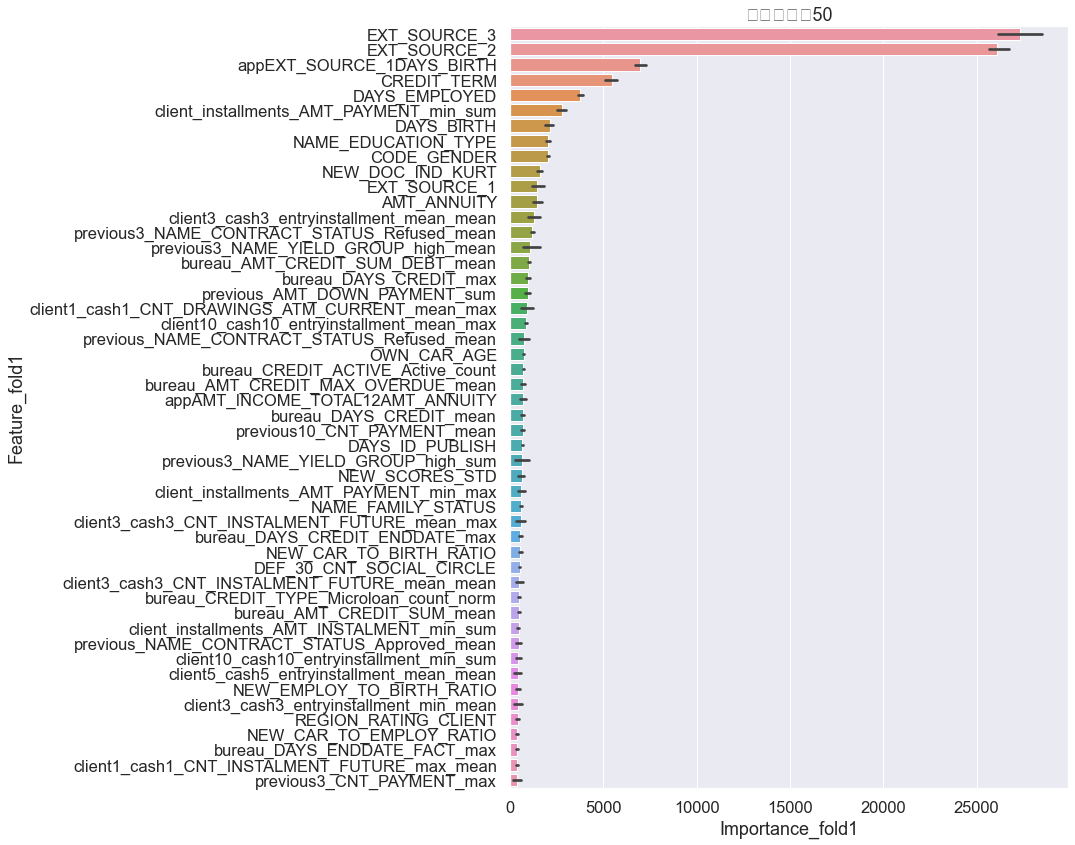

In [222]:
indices = feature_importance_plot(feat_df)
important_list = list(set(indices.iloc[:200, 0].values.tolist()))
if 'SK_ID_CURR' not in important_list:
    important_list.append('SK_ID_CURR')
train_df = train_df[important_list]
train_df = pd.concat([train_df, train_y], axis=1, sort=False)
test_df= test_df[important_list]

In [223]:
train_df.to_pickle('all_table_lag_train_df.pkl')
test_df.to_pickle('all_table_lag_test_df.pkl')

# 諸々調整

In [226]:
train_df = pd.read_pickle('../home credit/all_table_lag_train_df.pkl')
test_df = pd.read_pickle('../home credit/all_table_lag_test_df.pkl')

for c in train_df.columns:
    if train_df[c].dtypes == 'bool':
        train_df[c] = train_df[c].astype(np.int8)
        
for c in test_df.columns:
    if test_df[c].dtypes == 'bool':
        test_df[c] = test_df[c].astype(np.int8)
        
train_y = train_df['TARGET']
train_df.drop('TARGET', axis=1, inplace=True)

train_df = rename_data(train_df)
test_df = rename_data(test_df)

In [ ]:
model = lgb.LGBMClassifier(
            nthread=4,
            n_estimators=1000,
            learning_rate=0.1,
            maxdepth=4,
            num_leaves=13,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, 
            importance_type='gain')

pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df, train_y, test_df, 10)

Training until validation scores don't improve for 10 rounds


In [ ]:
indices = feature_importance_plot(feat_df)

In [ ]:
sub = application_test[['SK_ID_CURR']].copy()
sub['TARGET'] = preds_test
sub.to_csv('sub.csv', index= False)
#